Problem 02:

In [10]:
import csv
import pandas as pd
import numpy as np

path = "../../data/moores.csv"

rows = []
with open(path, "r", encoding="utf-8", newline="") as f:
    for row in csv.reader(f, skipinitialspace=True):
        if not row:
            continue
        # skip comment lines
        if row[0].startswith("#"):
            continue
        rows.append(row)

# If the first non-comment row is a header, use it
header = rows[0]
data = rows[1:]

df = pd.DataFrame(data, columns=header)

# Clean numeric columns
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Transistor Count"] = pd.to_numeric(df["Transistor Count"], errors="coerce")

# Keep only rows with Year and Transistor Count
df = df.dropna(subset=["Year", "Transistor Count"])

df.head()


,Name,Transistor Count,Year,Manufacturer,Process,Area,Source File
0,Transistor Computer,92.0,1953,University of Manchester,,,Transistor_count_8.csv
1,TRADIC,700.0,1954,Bell Labs,,,Transistor_count_8.csv
2,Transistor Computer (full size),250.0,1955,University of Manchester,,,Transistor_count_8.csv
3,IBM 608,3000.0,1955,IBM,,,Transistor_count_8.csv
4,ETL Mark III,130.0,1956,Electrotechnical Laboratory,,,Transistor_count_8.csv


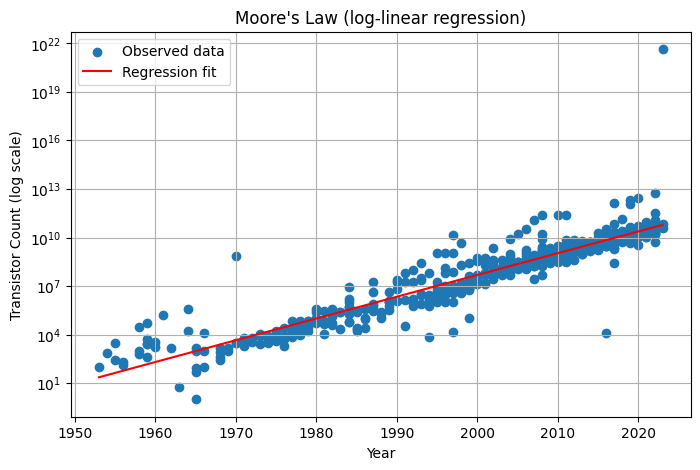

In [11]:
import matplotlib.pyplot as plt
import numpy as np

year = df["Year"].values
trans = df["Transistor Count"].values

# log-linear regression: ln(trans) = a*year + b
a, b = np.polyfit(year, np.log(trans), 1)

year_fit = np.linspace(year.min(), year.max(), 200)
trans_fit = np.exp(a * year_fit + b)

plt.figure(figsize=(8,5))
plt.scatter(year, trans, label="Observed data")
plt.plot(year_fit, trans_fit, label="Regression fit", color="red")

plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Transistor Count (log scale)")
plt.title("Moore's Law (log-linear regression)")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
import numpy as np

# Sort data by year (important)
df_sorted = df.sort_values("Year")

def compute_doubling_time(year, transistors):
    """
    Computes doubling time from log-linear regression.
    ln(N) = a*year + b  ->  doubling time = ln(2)/a
    """
    a, b = np.polyfit(year, np.log(transistors), 1)
    return np.log(2) / a

# Full dataset
dt_full = compute_doubling_time(
    df_sorted["Year"].values,
    df_sorted["Transistor Count"].values
)

# First 10 years
df_first = df_sorted.iloc[:10]
dt_first = compute_doubling_time(
    df_first["Year"].values,
    df_first["Transistor Count"].values
)

# Last 10 years
df_last = df_sorted.iloc[-10:]
dt_last = compute_doubling_time(
    df_last["Year"].values,
    df_last["Transistor Count"].values
)

# Display results
print("Transistor Doubling Time Estimates")
print("---------------------------------")
print(f"Full dataset     : {dt_full:.2f} years")
print(f"First 10 years   : {dt_first:.2f} years")
print(f"Last 10 years    : {dt_last:.2f} years")
print("Moore's Law claim: ~2 years")


Transistor Doubling Time Estimates
---------------------------------
Full dataset     : 2.24 years
First 10 years   : 1.41 years
Last 10 years    : 0.09 years
Moore's Law claim: ~2 years


Problem 03:

In [13]:
import numpy as np
import time
import gc

# -----------------------------
# 1) Create a large 2D array
# -----------------------------
N = 2000  # change to 10000 if you have enough RAM and patience
rng = np.random.default_rng(0)
A = rng.random((N, N), dtype=np.float64)  # uniform(0,1)

# -----------------------------
# 2) Two pure-Python loop sums
# -----------------------------
def sum_row_major(arr):
    s = 0.0
    n0, n1 = arr.shape
    for i in range(n0):          # row index outer
        for j in range(n1):      # col index inner (contiguous in C-order)
            s += arr[i, j]
    return s

def sum_col_major(arr):
    s = 0.0
    n0, n1 = arr.shape
    for j in range(n1):          # col index outer
        for i in range(n0):      # row index inner (strided in C-order)
            s += arr[i, j]
    return s

# -----------------------------
# 3) Timing helper (repeat >= 30)
# -----------------------------
def time_func(func, *args, repeats=30, warmup=2):
    # Warm-up runs (to reduce first-run effects)
    for _ in range(warmup):
        _ = func(*args)
    gc.collect()

    times = []
    last_val = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        last_val = func(*args)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.array(times), last_val

repeats = 30

# Row-major timing
t_row, s_row = time_func(sum_row_major, A, repeats=repeats)

# Column-major timing
t_col, s_col = time_func(sum_col_major, A, repeats=repeats)

# NumPy built-in timing
t_np, s_np = time_func(np.sum, A, repeats=repeats)

# -----------------------------
# 4) Results + sanity check
# -----------------------------
# Compare sums (they should be very close)
max_abs_diff = max(abs(s_row - s_np), abs(s_col - s_np))

print(f"Array shape: {A.shape}, dtype: {A.dtype}")
print(f"Repeat runs: {repeats}")
print()
print("Average time (seconds) ± std:")
print(f"  Python loops (row-major):    {t_row.mean():.6f} ± {t_row.std():.6f}")
print(f"  Python loops (column-major): {t_col.mean():.6f} ± {t_col.std():.6f}")
print(f"  NumPy sum:                   {t_np.mean():.6f} ± {t_np.std():.6f}")
print()
print("Speed ratios (bigger = row/col slower than NumPy):")
print(f"  row-major / NumPy:    {t_row.mean()/t_np.mean():.1f}×")
print(f"  column-major / NumPy: {t_col.mean()/t_np.mean():.1f}×")
print(f"  column-major / row-major: {t_col.mean()/t_row.mean():.2f}×")
print()
print(f"Sanity check (max |difference| vs NumPy): {max_abs_diff:.6e}")


Array shape: (2000, 2000), dtype: float64
Repeat runs: 30

Average time (seconds) ± std:
  Python loops (row-major):    0.265783 ± 0.002813
  Python loops (column-major): 0.266379 ± 0.001974
  NumPy sum:                   0.000472 ± 0.000015

Speed ratios (bigger = row/col slower than NumPy):
  row-major / NumPy:    562.6×
  column-major / NumPy: 563.9×
  column-major / row-major: 1.00×

Sanity check (max |difference| vs NumPy): 1.334120e-07


Problem 04:


In [16]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask.array as da
from dask.distributed import Client, LocalCluster

def zscore_dask(shape, chunks=(2000, 2000), seed=0):
    """
    Create a Dask random array and compute z-score: (x - mean) / std.
    Returns the lazy z-score array (not computed yet).
    """
    rs = da.random.RandomState(seed)
    x = rs.random(shape, chunks=chunks)  # uniform(0,1)
    mu = x.mean()
    sigma = x.std()
    z = (x - mu) / sigma
    return z

def run_once_strong(n_workers, shape, chunks, threads_per_worker=1):
    """
    Strong scaling: fixed shape, vary cores/workers.
    Times compute() of z-score array.
    """
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=threads_per_worker,
        processes=True,   # separate processes generally better for CPU
        dashboard_address=None
    )
    client = Client(cluster)

    try:
        z = zscore_dask(shape, chunks=chunks, seed=0)

        # Warm-up (build graph + a small compute)
        _ = z.mean().compute()

        t0 = time.perf_counter()
        _ = z.compute()
        t1 = time.perf_counter()

        return t1 - t0
    finally:
        client.close()
        cluster.close()


In [17]:
# --- Strong scaling settings ---
N = 8000  # replace with 20000 if you have enough RAM
shape = (N, N)
chunks = (2000, 2000)

cores_list = [1, 2, 3, 4]
times = []

for p in cores_list:
    t = run_once_strong(n_workers=p, shape=shape, chunks=chunks, threads_per_worker=1)
    times.append(t)
    print(f"Cores={p}, time={t:.3f} s")

T1 = times[0]
speedup = [T1/t for t in times]
efficiency = [s/p for s, p in zip(speedup, cores_list)]

df_strong = pd.DataFrame({
    "cores": cores_list,
    "time_s": times,
    "speedup": speedup,
    "efficiency": efficiency
})

df_strong


Cores=1, time=1.068 s
Cores=2, time=0.954 s
Cores=3, time=0.912 s
Cores=4, time=0.919 s


,cores,time_s,speedup,efficiency
0,1,1.068236,1.000000,1.000000
1,2,0.953918,1.119841,0.559920
2,3,0.912129,1.171146,0.390382
3,4,0.919481,1.161781,0.290445


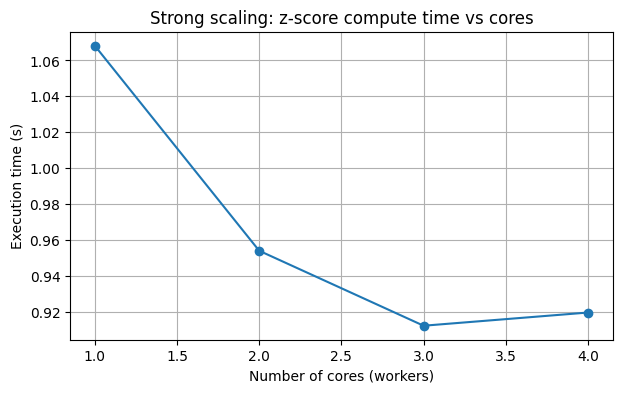

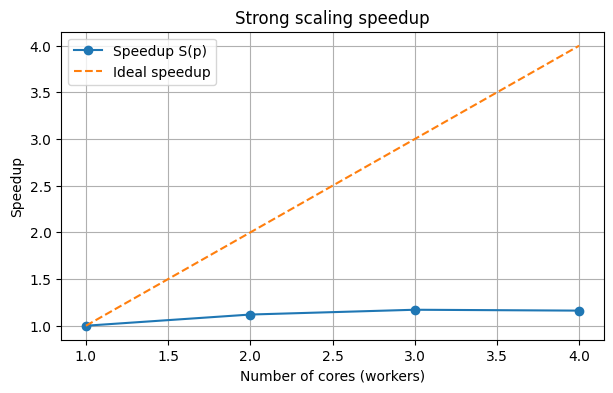

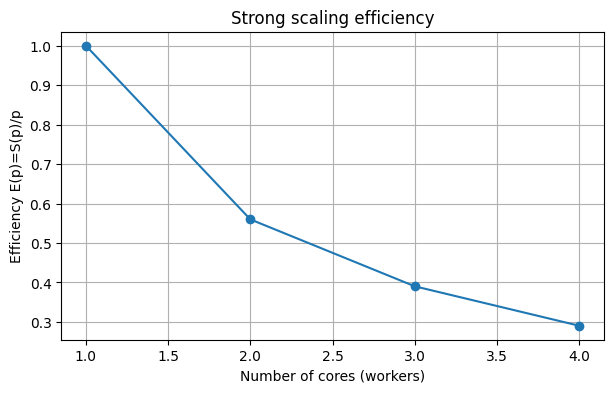

In [18]:
plt.figure(figsize=(7,4))
plt.plot(df_strong["cores"], df_strong["time_s"], marker="o")
plt.xlabel("Number of cores (workers)")
plt.ylabel("Execution time (s)")
plt.title("Strong scaling: z-score compute time vs cores")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(df_strong["cores"], df_strong["speedup"], marker="o", label="Speedup S(p)")
plt.plot(df_strong["cores"], df_strong["cores"], linestyle="--", label="Ideal speedup")
plt.xlabel("Number of cores (workers)")
plt.ylabel("Speedup")
plt.title("Strong scaling speedup")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(df_strong["cores"], df_strong["efficiency"], marker="o")
plt.xlabel("Number of cores (workers)")
plt.ylabel("Efficiency E(p)=S(p)/p")
plt.title("Strong scaling efficiency")
plt.grid(True)
plt.show()


In [19]:
def run_once_weak(n_workers, base_N, chunks, threads_per_worker=1):
    Np = int(base_N * np.sqrt(n_workers))
    shape = (Np, Np)
    return run_once_strong(n_workers=n_workers, shape=shape, chunks=chunks, threads_per_worker=threads_per_worker), shape

base_N = 8000  # this is the 1-core size
cores_list = [1, 2, 3, 4]

weak_times = []
weak_shapes = []

for p in cores_list:
    t, shp = run_once_weak(n_workers=p, base_N=base_N, chunks=chunks, threads_per_worker=1)
    weak_times.append(t)
    weak_shapes.append(shp)
    print(f"Cores={p}, shape={shp}, time={t:.3f} s")

df_weak = pd.DataFrame({
    "cores": cores_list,
    "shape": weak_shapes,
    "time_s": weak_times
})

df_weak


Cores=1, shape=(8000, 8000), time=1.124 s
Cores=2, shape=(11313, 11313), time=1.700 s
Cores=3, shape=(13856, 13856), time=2.195 s
Cores=4, shape=(16000, 16000), time=2.901 s


,cores,shape,time_s
0,1,"(8000, 8000)",1.123754
1,2,"(11313, 11313)",1.699759
2,3,"(13856, 13856)",2.195249
3,4,"(16000, 16000)",2.900776


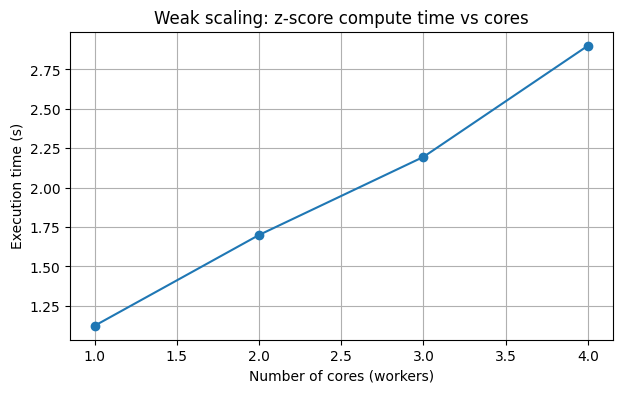

In [20]:
plt.figure(figsize=(7,4))
plt.plot(df_weak["cores"], df_weak["time_s"], marker="o")
plt.xlabel("Number of cores (workers)")
plt.ylabel("Execution time (s)")
plt.title("Weak scaling: z-score compute time vs cores")
plt.grid(True)
plt.show()
